Adi Maman

Eran Fishbien

# **Imports**

In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import time

In [131]:
# Device configuration - using GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# Q1 **The forward propagation process**


In [132]:
def initialize_parameters(layer_dims):
    """
    Initializes the weights and biases for a neural network using He initialization.

    Args:
        layer_dims (list of int): Dimensions of each layer in the network.

    Returns:
        dict: A dictionary containing the initialized weights (W1, W2, ..., WL) and biases (b1, b2, ..., bL) for each layer.
              Weights are initialized with (Kaiming) He initialization and biases are initialized to zero.
    """
    parameters = {}  # Dictionary to store the weights and biases

    for l in range(1, len(layer_dims)):
        # Get the size of the current and previous layers
        size_current_layer = layer_dims[l]
        size_previous_layer = layer_dims[l - 1]

        # He initialization factor
        he_factor = np.sqrt(2 / size_current_layer)

        # Initialize weights with He initialization
        parameters[f'W{l}'] = torch.FloatTensor(np.random.randn(size_current_layer, size_previous_layer) * he_factor).to(device)

        # Initialize biases to zeros
        parameters[f'b{l}'] = torch.zeros((size_current_layer, 1), dtype=torch.float32).to(device)

    return parameters

In [133]:
def linear_forward(A, W, b):
    """
    Computes the linear part of forward propagation for a single layer.

    The function calculates Z = W * A + b, where:
    - A is the activations from the previous layer
    - W is the weight matrix of the current layer
    - b is the bias vector of the current layer

    Args:
        A (torch.Tensor): Activations from the previous layer, shape (size of previous layer, number of examples).
        W (torch.Tensor): Weight matrix for the current layer, shape (size of current layer, size of previous layer).
        b (torch.Tensor): Bias vector for the current layer, shape (size of current layer, 1).

    Returns:
        tuple:
            Z (torch.Tensor): Linear component of the activation function, shape (size of current layer, number of examples).
            linear_cache (dict): A dictionary containing inputs `A`, `W`, and `b`, used for backward propagation.
    """
    # Compute the linear transformation Z = W * A + b
    Z = torch.matmul(W, A) + b

    # Cache the inputs for use during backward propagation
    linear_cache = {"A": A, "W": W, "b": b}

    return Z, linear_cache

In [134]:
def softmax(Z):
    """
    Applies the softmax activation function to the input tensor.

    The softmax function transforms the input into a probability distribution over classes.
    It is defined as:
        softmax(z_i) = exp(z_i) / sum(exp(z_j)), for all j

    Args:
        Z (torch.Tensor): Input tensor, shape (number of classes, number of examples).

    Returns:
        tuple:
            A (torch.Tensor): Output tensor after applying softmax, shape (number of classes, number of examples).
                             Each column represents the probability distribution over classes for one example.
            activation_cache (torch.Tensor): Cached input tensor `Z`, useful for backward propagation.
    """
    # Cache the input Z for backward propagation
    activation_cache = Z

    # Subtract the max value from Z for numerical stability
    Z = Z - torch.max(Z, dim=0, keepdim=True).values

    # Compute the exponentials of the adjusted Z
    exp_Z = torch.exp(Z)

    # Normalize the exponentials to get the probabilities
    A = exp_Z / torch.sum(exp_Z, dim=0, keepdim=True)

    return A, activation_cache

In [135]:
def relu(Z):
    """
    Applies the ReLU activation function.

    The ReLU function is defined as:     relu(z) = max(0, z)
    It replaces all negative values in the input tensor with 0, while keeping positive values unchanged.

    Args:
        Z (torch.Tensor): Input tensor, shape (size of current layer, number of examples).

    Returns:
        tuple:
            A (torch.Tensor): Output tensor after applying ReLU, same shape as `Z`.
                              Contains non-negative values (0 for all negative inputs).
            activation_cache (torch.Tensor): Cached input tensor `Z`, useful for backward propagation.
    """
    # Apply ReLU activation: Replace negative values with 0
    A = torch.maximum(torch.zeros_like(Z).to(Z.device), Z)

    # Cache the input Z for backward propagation
    activation_cache = Z

    return A, activation_cache

In [136]:
def linear_activation_forward(A_prev, W, B, activation):
    """
    Implements the forward propagation for a single layer, consisting of a
    linear transformation followed by an activation function.

    Args:
        A_prev (torch.Tensor): Activations from the previous layer, shape (size of previous layer, number of examples).
        W (torch.Tensor): Weight matrix for the current layer, shape (size of current layer, size of previous layer).
        B (torch.Tensor): Bias vector for the current layer, shape (size of current layer, 1).
        activation (str): The activation function to apply. Options are "relu" or "softmax".

    Returns:
        tuple:
            A (torch.Tensor): Output of the activation function, shape depends on the layer and activation.
            cache (dict): A dictionary containing:
                          - "linear_cache": Cache from the linear step (A_prev, W, B).
                          - "activation_cache": Cache from the activation step (Z).

    Raises:
        ValueError: If the specified activation function is not supported.

    Notes:
        - For ReLU, the activation function is applied element-wise.
        - For Softmax, the activation function outputs a probability distribution over classes.
    """
    # Perform the linear step: Z = W * A_prev + B
    Z, linear_cache = linear_forward(A_prev, W, B)

    # Apply the specified activation function
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        A, activation_cache = softmax(Z)
    else:
        raise ValueError(f"Unsupported activation: {activation}. Please use 'softmax' or 'relu'.")

    # Combine the caches for use in backward propagation
    cache = {"linear_cache": linear_cache, "activation_cache": activation_cache}

    return A, cache

In [137]:
def l_model_forward(X, parameters, use_batchnorm=False):
    """
    Implements the forward propagation for the entire network.

    The network architecture follows the pattern:
        [LINEAR -> RELU]*(L-1) -> LINEAR -> SOFTMAX

    Args:
        X (torch.Tensor): Input data, shape (input size, number of examples).
        parameters (dict): Dictionary containing weights (W1, W2, ..., WL)
                           and biases (b1, b2, ..., bL) for the L-layer network.
        use_batchnorm (bool): Whether to apply batch normalization after each ReLU activation.
                              Defaults to False.

    Returns:
        tuple:
            AL (torch.Tensor): The final activation values (probabilities), shape depends on the output layer.
            caches (list): A list of caches for each layer, where each cache contains:
                           - "linear_cache": Cache from the linear step (A_prev, W, B).
                           - "activation_cache": Cache from the activation step (Z).

    Notes:
        - Batch normalization (if enabled) normalizes the activation values after ReLU.
        - The final layer uses the softmax activation function to output probabilities.
    """
    caches = []  # To store caches for all layers
    A = X  # Initialize activations with input data
    L = len(parameters) // 2  # Number of layers in the network

    # Forward pass through L-1 layers with ReLU activation
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters[f'W{l}'], parameters[f'b{l}'], "relu")

        # Apply batch normalization if enabled:
        if use_batchnorm:
            A = apply_batchnorm(A)

        # Store the cache for the current layer
        caches.append(cache)

    # Forward pass through the final layer with Softmax activation
    AL, cache = linear_activation_forward(A, parameters[f'W{L}'], parameters[f'b{L}'], "softmax")
    caches.append(cache)  # store the cache for the final layer

    return AL, caches

In [138]:
def compute_cost(AL, Y, parameters=None, L2=0.0):
    """
    Computes the cross-entropy cost with optional L2 regularization.

    Args:
        AL (torch.Tensor): Predicted probabilities (output of the softmax layer),
                           shape (number of classes, number of examples).
        Y (torch.Tensor): One-hot encoded true labels (ground truth),
                          shape (number of classes, number of examples).
        parameters (dict, optional): Dictionary containing the weights (W1, W2, ..., WL).
                                      If provided, L2 regularization is applied. Default is None.
        L2 (float, optional): Regularization strength for L2 regularization. Default is 0.0.

    Returns:
        cost (torch.Tensor): The total cost, including cross-entropy and L2 regularization (if enabled).

    Notes:
        - Cross-entropy loss ensures that the predicted probabilities are close to the true labels.
        - L2 regularization penalizes large weights, helping to prevent overfitting.
        - The `torch.clamp` function is used to ensure numerical stability by avoiding log(0).
    """
    m = Y.shape[1]  # Number of examples
    epsilon = 1e-15  # Small constant to prevent log(0)

    # Ensure AL values are in the range (epsilon, 1 - epsilon) for numerical stability
    AL = torch.clamp(AL, epsilon, 1.0 - epsilon)

    # Compute cross-entropy loss
    cost = -torch.mean(torch.sum(Y * torch.log(AL), dim=0))

    # Compute L2 regularization cost (if parameters are provided)
    if parameters:
        L2_cost = 0
        num_layers = len(parameters) // 2  # Number of layers in the network
        for l in range(1, num_layers + 1):
            L2_cost += torch.sum(torch.square(parameters[f'W{l}']))
        # Add L2 regularization to the cost:
        cost += (L2 / (2 * m)) * L2_cost

    return cost

In [139]:
def apply_batchnorm(A):
    """
    Applies batch normalization to the activations of a layer.

    Batch normalization normalizes the inputs to have a mean of 0 and a variance of 1.

    Args:
        A (torch.Tensor): Activations from the current layer, shape (number of neurons, number of examples).

    Returns:
        NA (torch.Tensor): Normalized activations, same shape as input `A`.

    Notes:
        - The mean and variance are computed across the batch (examples) for each neuron.
        - A small constant `epsilon` is added to the variance to ensure numerical stability.
    """
    # Compute the mean of activations for each neuron across the batch
    mean = torch.mean(A, dim=1, keepdim=True)

    # Compute the variance of activations for each neuron across the batch
    var = torch.var(A, dim=1, keepdim=True, unbiased=False)

    epsilon = 1e-8 # Small constant for numerical stability

    # Normalize activations: (A - mean) / sqrt(var + epsilon)
    A_norm = (A - mean) / torch.sqrt(var + epsilon)

    return A_norm

# Q2 **The backward propagation process**


In [140]:
def linear_backward(dZ, cache, L2=0.00):
    """
    Implements the linear portion of backward propagation for a single layer.

    This function computes the gradients of the cost with respect to the
    activations, weights, and biases of the current layer.

    Args:
        dZ (torch.Tensor): Gradient of the cost with respect to the linear output (Z) of the current layer,
                           shape (size of current layer, number of examples).
        cache (dict): Dictionary containing:
                      - "A": Activations from the previous layer (size of previous layer, number of examples).
                      - "W": Weights of the current layer (size of current layer, size of previous layer).
                      - "b": Biases of the current layer (size of current layer, 1).
        L2 (float, optional): Regularization strength for L2 regularization. Default is 0.00 (no regularization).

    Returns:
        tuple:
            dA_prev (torch.Tensor): Gradient of the cost with respect to activations of the previous layer,
                                    shape (size of previous layer, number of examples).
            dW (torch.Tensor): Gradient of the cost with respect to the weights of the current layer,
                               shape (size of current layer, size of previous layer).
            db (torch.Tensor): Gradient of the cost with respect to the biases of the current layer,
                               shape (size of current layer, 1).

    Notes:
        - The L2 parameter adds a regularization term to the gradient of the weights (dW).
        - Gradients are computed using matrix operations for efficiency.
    """
    # Extract values from the cache:
    A_prev = cache["A"]
    W = cache["W"]
    b = cache["b"]

    m = A_prev.shape[1]  # Number of examples

    # Compute gradients
    dW = (torch.mm(dZ, A_prev.T) / m) + (L2 / m) * W  # (L2 / m) * W = 0 if L2=0 (no regularization)
    db = torch.sum(dZ, dim=1, keepdim=True) / m
    dA_prev = torch.mm(W.T, dZ)

    return dA_prev, dW, db

In [141]:
def linear_activation_backward(dA, cache, activation, L2=0.00):
    """
    Implements the backward propagation for a single layer: LINEAR->ACTIVATION.

    Args:
        dA (torch.Tensor): Gradient of the cost with respect to the activation of the current layer,
                           shape (size of current layer, number of examples).
        cache (dict): Dictionary containing:
                      - "linear_cache": Cache from the linear step (A_prev, W, b).
                      - "activation_cache": Cache from the activation step (Z).
        activation (str): The activation function used in the forward pass. Options are "relu" or "softmax".
        L2 (float, optional): Regularization strength for L2 regularization. Default is 0.00 (no regularization).

    Returns:
        tuple:
            dA_prev (torch.Tensor): Gradient of the cost with respect to activations of the previous layer,
                                    shape (size of previous layer, number of examples).
            dW (torch.Tensor): Gradient of the cost with respect to the weights of the current layer,
                               shape (size of current layer, size of previous layer).
            db (torch.Tensor): Gradient of the cost with respect to the biases of the current layer,
                               shape (size of current layer, 1).

    Raises:
        ValueError: If an unsupported activation function is provided.
    """
    # Extract caches:
    linear_cache = cache["linear_cache"]
    activation_cache = cache["activation_cache"]

    # Compute dZ based on the activation function
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)
    else:
        raise ValueError(f"Unsupported activation: {activation}. Please use 'softmax' or 'relu'.")

    # Compute gradients using linear backward propagation
    dA_prev, dW, db = linear_backward(dZ, linear_cache, L2)

    return dA_prev, dW, db

In [142]:
def relu_backward(dA, activation_cache):
    """
    Implements the backward propagation for the ReLU activation function.

    Args:
        dA (torch.Tensor): Gradient of the cost with respect to the activation output,
                           shape (size of current layer, number of examples).
        activation_cache (torch.Tensor): Cached input tensor (Z) from the forward propagation step,
                                         shape (size of current layer, number of examples).

    Returns:
        dZ (torch.Tensor): Gradient of the cost with respect to the linear output (Z),
                      same shape as `dA`.

    Notes:
        - The gradient is passed through unchanged for positive Z values.
        - For Z <= 0, the gradient is set to 0 (ReLU's derivative is 0 for non-positive inputs).
    """
    Z = activation_cache  # Retrieve Z from the cache
    dZ = dA.clone()       # Create a copy of dA to preserve the original tensor

    # Apply ReLU derivative: dZ = dA if Z > 0; otherwise dZ = 0
    dZ[Z <= 0] = 0

    return dZ

In [143]:
def softmax_backward(dA, activation_cache):
    """
    Implements the backward propagation for the softmax activation function.

    Args:
        dA (torch.Tensor): Gradient of the cost with respect to the activation output,
                           shape (number of classes, number of examples).
        activation_cache (torch.Tensor): Cached input tensor (Z) from the forward propagation step,
                                         shape (number of classes, number of examples).

    Returns:
        torch.Tensor: Gradient of the cost with respect to the linear output (Z),
                      shape (number of classes, number of examples).

    Notes:
        When the softmax function is combined with cross-entropy loss during training,
        the gradient `dA` provided is already computed efficiently as `softmax(Z) - Y`.
        In this case, the function simply returns `dA` as `dZ`, since the gradient
        of the softmax function is implicitly handled.
    """
    return dA

In [144]:
def l_model_backward(AL, Y, caches, L2=0.0):
    """
    Implements backward propagation for the entire L-layer neural network.

    Args:
        AL (torch.Tensor): Probability predictions from the forward propagation (output of softmax),
                           shape (number of classes, number of examples).
        Y (torch.Tensor): True labels (one-hot encoded), shape (number of classes, number of examples).
        caches (list): A list of caches from the forward propagation, where each cache contains:
                       - "linear_cache": Cache from the linear step (A_prev, W, b).
                       - "activation_cache": Cache from the activation step (Z).
        L2 (float, optional): Regularization strength for L2 regularization. Default is 0.0 (no regularization).

    Returns:
        grads (dict): Gradients for all layers, including:
              - dA[l]: Gradient of the cost with respect to activations of layer l.
              - dW[l+1]: Gradient of the cost with respect to weights of layer l+1.
              - db[l+1]: Gradient of the cost with respect to biases of layer l+1.

    Notes:
        - The softmax activation is used in the final layer with cross-entropy loss.
        - ReLU activation is used for all hidden layers.
        - L2 regularization is applied to the weights if L2 > 0.
    """
    grads = {}  # Dictionary to store gradients
    L = len(caches)  # Number of layers

    # Step 1: Initialize backpropagation for the output layer
    dAL = AL - Y
    current_cache = caches[L-1]

    # Compute gradients for the final layer (softmax + linear step)
    grads[f"dA{L-1}"], grads[f"dW{L}"], grads[f"db{L}"] = linear_activation_backward(dAL, current_cache, "softmax", L2)

    # Step 2: Backward propagation through hidden layers
    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        dA = grads[f"dA{l+1}"]

        # Compute gradients for the current layer (ReLU + linear step)
        dA_prev, dW, db = linear_activation_backward(dA, current_cache, "relu", L2)

        # Store gradients in the dictionary
        grads[f"dA{l}"] = dA_prev
        grads[f"dW{l+1}"] = dW
        grads[f"db{l+1}"] = db

    return grads

In [145]:
def update_parameters(parameters, grads, learning_rate):
    """
    Updates the parameters of the neural network using gradient descent.

    Args:
        parameters (dict): Dictionary containing the network parameters (Weights & Biases) for each layer.

        grads (dict): Dictionary containing the gradients (Gradients of weights & Gradients of biases) for each layer.

        learning_rate (float): Learning rate for gradient descent.

    Returns:
        dict: Updated parameters dictionary with the same keys as the input `parameters`.

    Notes:
        - Gradient descent updates weights as W = W - learning_rate * dW.
        - Gradient descent updates biases as b = b - learning_rate * db.
    """
    # Number of layers in the network (each layer has both W and b, so divide by 2):
    L = len(parameters) // 2

    # Update weights and biases for each layer:
    for l in range(1, L + 1):
        parameters[f"W{l}"] -= learning_rate * grads[f"dW{l}"]  # Update weights
        parameters[f"b{l}"] -= learning_rate * grads[f"db{l}"]  # Update biases

    return parameters

# Q3 **Network Model training**


In [146]:
# Define global variables outside the function  ### ? ###
ex_train_costs = []
ex_val_costs = []

In [147]:
def l_layer_model(X, Y, layers_dims, learning_rate=0.009, num_iterations=100, batch_size=32, use_batchnorm=False, L2=0.0):
    """
    Implements a L-layer neural network with ReLU activations for hidden layers
    and a softmax activation for the output layer, with optional batch normalization and L2 regularization.

    Args:
    X: Input data, shape (height*width, number_of_examples).
    Y: True labels, one-hot encoded, shape (num_classes, number_of_examples).
    layers_dims (list): List containing the dimensions of each layer, including input and output.
    learning_rate (float): Learning rate for gradient descent.
    num_iterations (int): Number of training iterations. defult to 100.
    batch_size (int): Number of examples in a single training batch. defult to 32.
    use_batchnorm (bool, optional): Whether to apply batch normalization. Defaults to False.
    L2 (float, optional): L2 regularization. Defaults to 0.0 (No regularization).

    Returns:
    parameters (dict): Trained parameters of the network.
    costs (list): List of cost values logged every 100 iterations.
    """

    global ex_train_costs, ex_val_costs  # Declare global variables  ###?###
    # Reset global lists for this experiment
    ex_train_costs = []
    ex_val_costs = []

    m = X.shape[1]  # Number of examples

    costs_train = []
    costs_val = []

    # Divide into train and validation as asked (80%-20% ratio):
    train_size = int(0.8 * m)
    torch.manual_seed(10)
    indices = torch.randperm(m)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    X_train, X_val = X[:, train_indices], X[:, val_indices]
    Y_train, Y_val = Y[:, train_indices], Y[:, val_indices]

    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    batch_count = 1  # training batch counter

    # Training loop:
    for epoch in range(num_iterations):
        for i in range(0, X_train.shape[1], batch_size):

            # Get batch:
            end = min(i + batch_size, X_train.shape[1])
            X_train_batch = X_train[:, i:end]
            Y_train_batch = Y_train[:, i:end]

            # Forward propagation:
            AL, cache = l_model_forward(X_train_batch, parameters, use_batchnorm)

            # Backward propagation:
            grads = l_model_backward(AL, Y_train_batch, cache, L2)

            # Update parameters:
            parameters = update_parameters(parameters, grads, learning_rate)

            if batch_count % 100 == 0:
                # Compute training cost:
                cost = compute_cost(AL, Y_train_batch, parameters, L2)
                costs_train.append(cost)

                # Save to global variable                  ### ? ###
                ex_train_costs.append(cost.item())

                # print the cost:
                print(f"Cost after {batch_count} training steps: {round(cost.item(), 5)}")

                # Compute validation cost:
                AL_val, cache_val = l_model_forward(X_val, parameters, use_batchnorm)
                cost_val = compute_cost(AL_val, Y_val, parameters, L2)
                costs_val.append(cost_val.item())

                # Save to global variable             ### ? ###
                ex_val_costs.append(cost_val.item())

                # Check for early stopping & improvement threshold:
                if len(costs_val) > 1 and abs(costs_val[-2] - costs_val[-1]) < 0.00001:  # very small improvement threshold
                    train_accuracy = predict(X_train, Y_train, parameters, use_batchnorm)
                    val_accuracy = predict(X_val, Y_val, parameters, use_batchnorm)

                    # Helper function to print progress:
                    print_training_progress(parameters, epoch, batch_count, train_accuracy, val_accuracy, costs_train, costs_val)
                    return parameters, costs_train

            batch_count += 1

    # Final accuracy and summary:
    train_accuracy = predict(X_train, Y_train, parameters, use_batchnorm)
    val_accuracy = predict(X_val, Y_val, parameters, use_batchnorm)
    print_training_progress(parameters, epoch, batch_count, train_accuracy, val_accuracy, costs_train, costs_val)

    return parameters, costs_train

In [148]:
def predict(X, Y, parameters, use_batchnorm=False):
    """
    Predicts the labels for the input data and calculates the model accuracy.

    Args:
        X (torch.Tensor): Input data, shape (input size, number of examples).
        Y (torch.Tensor): True labels (one-hot encoded), shape (number of classes, number of examples).
        parameters (dict): Trained parameters of the model.
        use_batchnorm (bool, optional): Whether batch normalization was used during training. Default is False.

    Returns:
        accuracy (float): The accuracy of the model on the input data, as a value between 0 and 1.

    Notes:
        - Accuracy is computed as the percentage of correctly predicted labels.
        - Predicted labels are determined using `torch.argmax` on the output activations.
    """
    # Perform forward propagation
    AL, _ = l_model_forward(X, parameters, use_batchnorm)

    # Determine predicted labels (highest probability class)
    predictions = torch.argmax(AL, dim=0)

    # Determine true labels
    true_labels = torch.argmax(Y, dim=0)

    # Compute accuracy
    accuracy = (predictions == true_labels).float().mean().item()

    return accuracy

In [149]:
def print_training_progress(parameters, epoch, batch_count, train_accuracy, val_accuracy, costs_train, costs_val):
    """
    A helper function to print the training progress, including parameters, epoch details,
    accuracy metrics, and cost values for training and validation.

    Parameters
    ----------
    parameters : dict
        The parameters of the neural network learned during training.
    epoch : int
        The current epoch number during training.
    batch_count : int
        The current batch (or training step) count.
    train_accuracy : float
        The accuracy of the model on the training set at the current step.
    val_accuracy : float
        The accuracy of the model on the validation set at the current step.
    costs_train : list of float
        A list containing the training cost values recorded at each relevant step.
    costs_val : list of float
        A list containing the validation cost values recorded at each relevant step.

    Returns
    -------
    None
        This function prints the training progress to the console but does not return any value.
    """
    print("Parameters Network:\n", parameters)
    print(f"Epoch Number: {round(epoch, 4)}")
    print(f"Number of Iteration: {round(batch_count, 4)}")
    print(f"Costs Train: {round(costs_train[-1].item(), 4)}")
    print(f"Costs Validation: {round(costs_val[-1], 4)}")
    # print(f"Train Accuracy: {round(train_accuracy, 4)}")
    # print(f"Validation Accuracy: {round(val_accuracy, 4)}")

# Q4-5 **MNIST dataset**


**Load and preprocess MNIST DataSet**

In [150]:
def load_and_preprocess_mnist(batch_size=64):
    """
    Loads and preprocesses the MNIST dataset for use in a fully connected neural network.

    Args:
        batch_size (int, optional): Batch size for potential further mini-batch processing. Default is 64.

    Returns:
        tuple: Preprocessed datasets:
            - X_train (torch.Tensor): Training set features, shape (784, num_train_examples).
            - Y_train (torch.Tensor): Training set labels (one-hot encoded), shape (10, num_train_examples).
            - X_val (torch.Tensor): Validation set features, shape (784, num_val_examples).
            - Y_val (torch.Tensor): Validation set labels (one-hot encoded), shape (10, num_val_examples).
            - X_test (torch.Tensor): Test set features, shape (784, num_test_examples).
            - Y_test (torch.Tensor): Test set labels (one-hot encoded), shape (10, num_test_examples).

    Notes:
        - Images are flattened from (28, 28) to (784,) and scaled to [0, 1].
        - Labels are one-hot encoded to match the network output format.
        - The training set is split into 80% training and 20% validation sets.
    """
    # Define the transformation pipeline
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert PIL image to tensor
        transforms.Lambda(lambda x: x.view(-1))  # Flatten the image to shape (784,)
    ])

    # Load MNIST dataset
    mnist_train = datasets.MNIST(root='./', train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST(root='./', train=False, download=True, transform=transform)

    # Split the training dataset into training and validation sets
    train_size = int(0.8 * len(mnist_train))  # 80% for training
    val_size = len(mnist_train) - train_size  # Remaining 20% for validation
    train_dataset, val_dataset = random_split(mnist_train, [train_size, val_size])


    # Helper function to process datasets into (X, Y) format
    def process_dataset(dataset):
        data = torch.stack([sample[0] for sample in dataset])  # Stack all images
        labels = torch.tensor([sample[1] for sample in dataset])  # Stack all labels

        # Convert features and labels to desired format
        X = data.T  # Transpose to shape (784, num_examples)
        Y = F.one_hot(labels, num_classes=10).T.float()  # One-hot encode labels, shape (10, num_examples)

        return X.to(device), Y.to(device)  # Move to device (CPU/GPU)


    # Process the train, validation, and test datasets
    X_train, Y_train = process_dataset(train_dataset)
    X_val, Y_val = process_dataset(val_dataset)
    X_test, Y_test = process_dataset(mnist_test)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test

**Results Analysis**

In [151]:
def compare_hyperparameters(X_train, Y_train, X_val, Y_val, X_test, Y_test):
    """
    Compares different hyperparameter combinations and visualizes the results.

    Args:
        X_train, Y_train (torch.Tensor): Training data and labels.
        X_val, Y_val (torch.Tensor): Validation data and labels.
        X_test, Y_test (torch.Tensor): Test data and labels.

    Returns:
        list: Results of each experiment, including hyperparameters, accuracies, and training times.
    """
    results = []

    epochs = [50,100]
    batch_sizes = [32, 64, 128]
    lambda_values = [0.01,0.04]

    # Base configuration
    layers_dims = [784, 20, 7, 5, 10]
    learning_rate = 0.009
    use_batchnorm = False  # for Q4

    total_experiments = len(epochs) * len(batch_sizes) * len(lambda_values)
    experiment_count = 0

    for num_epochs in epochs:
        for batch_size in batch_sizes:
            for lambda_val in lambda_values:
                experiment_count += 1
                print(f"\nExperiment {experiment_count}/{total_experiments}")
                print(f"Training with: epochs={num_epochs}, batch_size={batch_size}, lambda={lambda_val}")

                # start time
                start_time = time.time()

                try:
                    # Train model
                    parameters, costs = l_layer_model(
                        X_train,
                        Y_train,
                        layers_dims=layers_dims,
                        learning_rate=learning_rate,
                        num_iterations=num_epochs,
                        batch_size=batch_size,
                        use_batchnorm=use_batchnorm,
                        L2=lambda_val
                    )

                    # total training time
                    training_time = time.time() - start_time

                    # Calculate accuracies
                    train_acc = predict(X_train, Y_train, parameters, use_batchnorm)
                    val_acc = predict(X_val, Y_val, parameters, use_batchnorm)
                    test_acc = predict(X_test, Y_test, parameters, use_batchnorm)

                    results.append({
                        'epochs': num_epochs,
                        'batch_size': batch_size,
                        'lambda': lambda_val,
                        'train_acc': train_acc,
                        'val_acc': val_acc,
                        'test_acc': test_acc,
                        'costs': costs,
                        'training_time': training_time
                    })

                    print(f"Training Time: {training_time:.2f} seconds")
                    print(f"Train Acc: {train_acc:.4%}, Val Acc: {val_acc:.4%}, Test Acc: {test_acc:.4%}") ### ? ###


                except Exception as e:
                    print(f"Error in experiment: {str(e)}")
                    continue

    if not results:
        print("No successful experiments to plot")
        return None

    # Plot results
    plot_hyperparameter_results(results, epochs, batch_sizes, lambda_values)

    # Identify best configuration
    best_result = max(results, key=lambda x: x['val_acc'])  ### ? ###
    print_best_configuration(best_result)

    return results


In [152]:
def plot_hyperparameter_results(results, epochs, batch_sizes, lambda_values):
    """
    Plots the results of hyperparameter experiments with all visualizations.
    """
    # 1. Learning Curves - 2x2 Grid
    plt.figure(figsize=(20, 15))

    # Create all possible combinations
    plot_positions = 1
    for epoch in epochs:
        for lambda_val in lambda_values:
            plt.subplot(2, 2, plot_positions)
            # Filter results for this specific configuration
            filtered_results = [r for r in results if r['epochs'] == epoch and r['lambda'] == lambda_val]
            plot_learning_curves(filtered_results, batch_sizes,
                               f"{epoch} Epochs, λ={lambda_val}")
            plot_positions += 1

    plt.tight_layout()
    plt.show()

    # 2. Train vs Validation Accuracy Plot
    plt.figure(figsize=(15, 8))
    plot_train_val_accuracies(results, epochs, batch_sizes, lambda_values)
    plt.show()

    # 3. Accuracy Table
    plot_accuracy_table(results, batch_sizes, epochs, lambda_values)

def plot_learning_curves(results, batch_sizes, title):
    """
    Helper function to plot learning curves for specific configuration
    """
    colors = {'32': 'blue', '64': 'orange', '128': 'green'}

    for batch_size in batch_sizes:
        result = next((r for r in results if r['batch_size'] == batch_size), None)
        if result:
            plt.plot(range(len(result['costs'])),
                    result['costs'],
                    color=colors[str(batch_size)],
                    label=f'Batch {batch_size}')

    plt.title(title, fontsize=10)
    plt.xlabel('Training Steps')
    plt.ylabel('Cost')
    plt.legend()
    plt.grid(True, alpha=0.3)

def plot_train_val_accuracies(results, epochs, batch_sizes, lambda_values):
    """
    Plots train and validation accuracies for all configurations
    """
    # Sort results by epoch, lambda, then batch size for consistent ordering
    sorted_results = sorted(results,
                          key=lambda x: (x['epochs'], x['lambda'], x['batch_size']))

    x = range(len(sorted_results))
    x_labels = []

    # Create labels for each configuration
    for r in sorted_results:
        label = f'E{r["epochs"]}\nL{r["lambda"]:.2f}\nS{r["batch_size"]}'
        x_labels.append(label)

    # Plot accuracies
    plt.plot(x, [r['train_acc'] for r in sorted_results], 'b-o', label='Train Acc')
    plt.plot(x, [r['val_acc'] for r in sorted_results], 'r-o', label='Val Acc')

    # Customize plot
    plt.xticks(x, x_labels, ha='right')
    plt.title('Train vs Validation Accuracy by Configuration')
    plt.xlabel('Configuration')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add vertical lines to separate different epoch-lambda combinations
    current_epoch = None
    current_lambda = None
    for i, r in enumerate(sorted_results):
        if current_epoch != r['epochs'] or current_lambda != r['lambda']:
            if i > 0:
                plt.axvline(x=i-0.5, color='gray', linestyle='--', alpha=0.3)
            current_epoch = r['epochs']
            current_lambda = r['lambda']

    plt.tight_layout()

def plot_accuracy_table(results, batch_sizes, epochs, lambda_values):
    """
    Creates a table showing test accuracies for different configurations
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.axis('tight')
    ax.axis('off')

    # Prepare data for table
    table_data = []
    table_colors = []
    min_acc = min(r['test_acc'] for r in results)
    max_acc = max(r['test_acc'] for r in results)

    # Create header
    header = ['Batch Size']
    for epoch in epochs:
        for lambda_val in lambda_values:
            header.append(f'E{epoch} L{lambda_val}')

    # Fill data rows
    for batch_size in batch_sizes:
        row = [batch_size]
        row_colors = ['white']

        for epoch in epochs:
            for lambda_val in lambda_values:
                result = next((r for r in results
                             if r['batch_size'] == batch_size
                             and r['epochs'] == epoch
                             and r['lambda'] == lambda_val), None)
                if result:
                    acc = result['test_acc']
                    row.append(f"{acc:.4f}")

                    # Color intensity based on accuracy
                    intensity = (acc - min_acc) / (max_acc - min_acc)
                    color = (1, 1, 1 - 0.3 * intensity)
                    row_colors.append(color)
                else:
                    row.append("N/A")
                    row_colors.append('white')

        table_data.append(row)
        table_colors.append(row_colors)

    # Create table
    table = ax.table(cellText=table_data,
                    colLabels=header,
                    cellColours=table_colors,
                    loc='center',
                    cellLoc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)

    plt.title("Test Accuracy for Different Configurations")
    plt.tight_layout()
    plt.show()

In [153]:
def print_best_configuration(best_result):
    """
    Prints the best hyperparameter configuration based on validation accuracy.
    """
    print("\nBest Configuration:")
    print(f"Epochs: {best_result['epochs']}")
    print(f"Batch Size: {best_result['batch_size']}")
    print(f"Lambda: {best_result['lambda']}")
    print(f"Training Time: {best_result['training_time']:.2f} seconds")
    print(f"Training Accuracy: {best_result['train_acc']:.4%}")
    print(f"Validation Accuracy: {best_result['val_acc']:.4%}")
    print(f"Test Accuracy: {best_result['test_acc']:.4%}")

**RUN The Model**

In [26]:
def run_experiment():
    """
    Runs the complete MNIST experiment, including loading the dataset,
    preprocessing, and performing hyperparameter comparison.

    Steps:
        1. Load and preprocess the MNIST dataset.
        2. Perform hyperparameter tuning by comparing different configurations.
        3. Return and optionally save the results.

    Returns:
        list: A list of dictionaries containing results for each hyperparameter configuration,
              including training time, accuracies, and cost values.

    Notes:
        - The function uses `load_and_preprocess_mnist` to prepare the dataset.
        - Hyperparameter tuning is performed using `compare_hyperparameters`.
    """
    print("Loading MNIST dataset ...")
    # Load and preprocess MNIST dataset
    X_train, Y_train, X_val, Y_val, X_test, Y_test = load_and_preprocess_mnist()

    print("\nStarting hyperparameter comparison...")
    # Compare different hyperparameter configurations
    results = compare_hyperparameters(X_train, Y_train, X_val, Y_val, X_test, Y_test)

    print("\nExperiment completed.")
    return results

Streaming output truncated to the last 5000 lines.
Cost after 28400 training steps: 0.51356
Cost after 28500 training steps: 0.64096
Cost after 28600 training steps: 0.30025
Cost after 28700 training steps: 0.36584
Cost after 28800 training steps: 0.77492
Cost after 28900 training steps: 0.61613
Cost after 29000 training steps: 1.07498
Cost after 29100 training steps: 0.33363
Cost after 29200 training steps: 0.54492
Parameters Network:
 {'W1': tensor([[ 0.4977,  0.4074, -0.5255,  ...,  0.5987, -0.5846,  0.2217],
        [ 0.5647,  0.2244,  0.0342,  ..., -0.2493, -0.0393, -0.2496],
        [-0.2072, -0.3768, -0.4448,  ..., -0.1569,  0.1034,  0.4046],
        ...,
        [ 0.1889, -0.2961,  0.1826,  ..., -0.1542,  0.2967, -0.1864],
        [ 0.2733, -0.0847,  0.0466,  ..., -0.1162,  0.3420, -0.3735],
        [-0.1213,  0.0065,  0.2631,  ..., -0.1005, -0.0433, -0.1735]]), 'b1': tensor([[-0.0397],
        [-0.0473],
        [ 0.2587],
        [-0.0510],
        [ 0.0088],
        [-0.0164

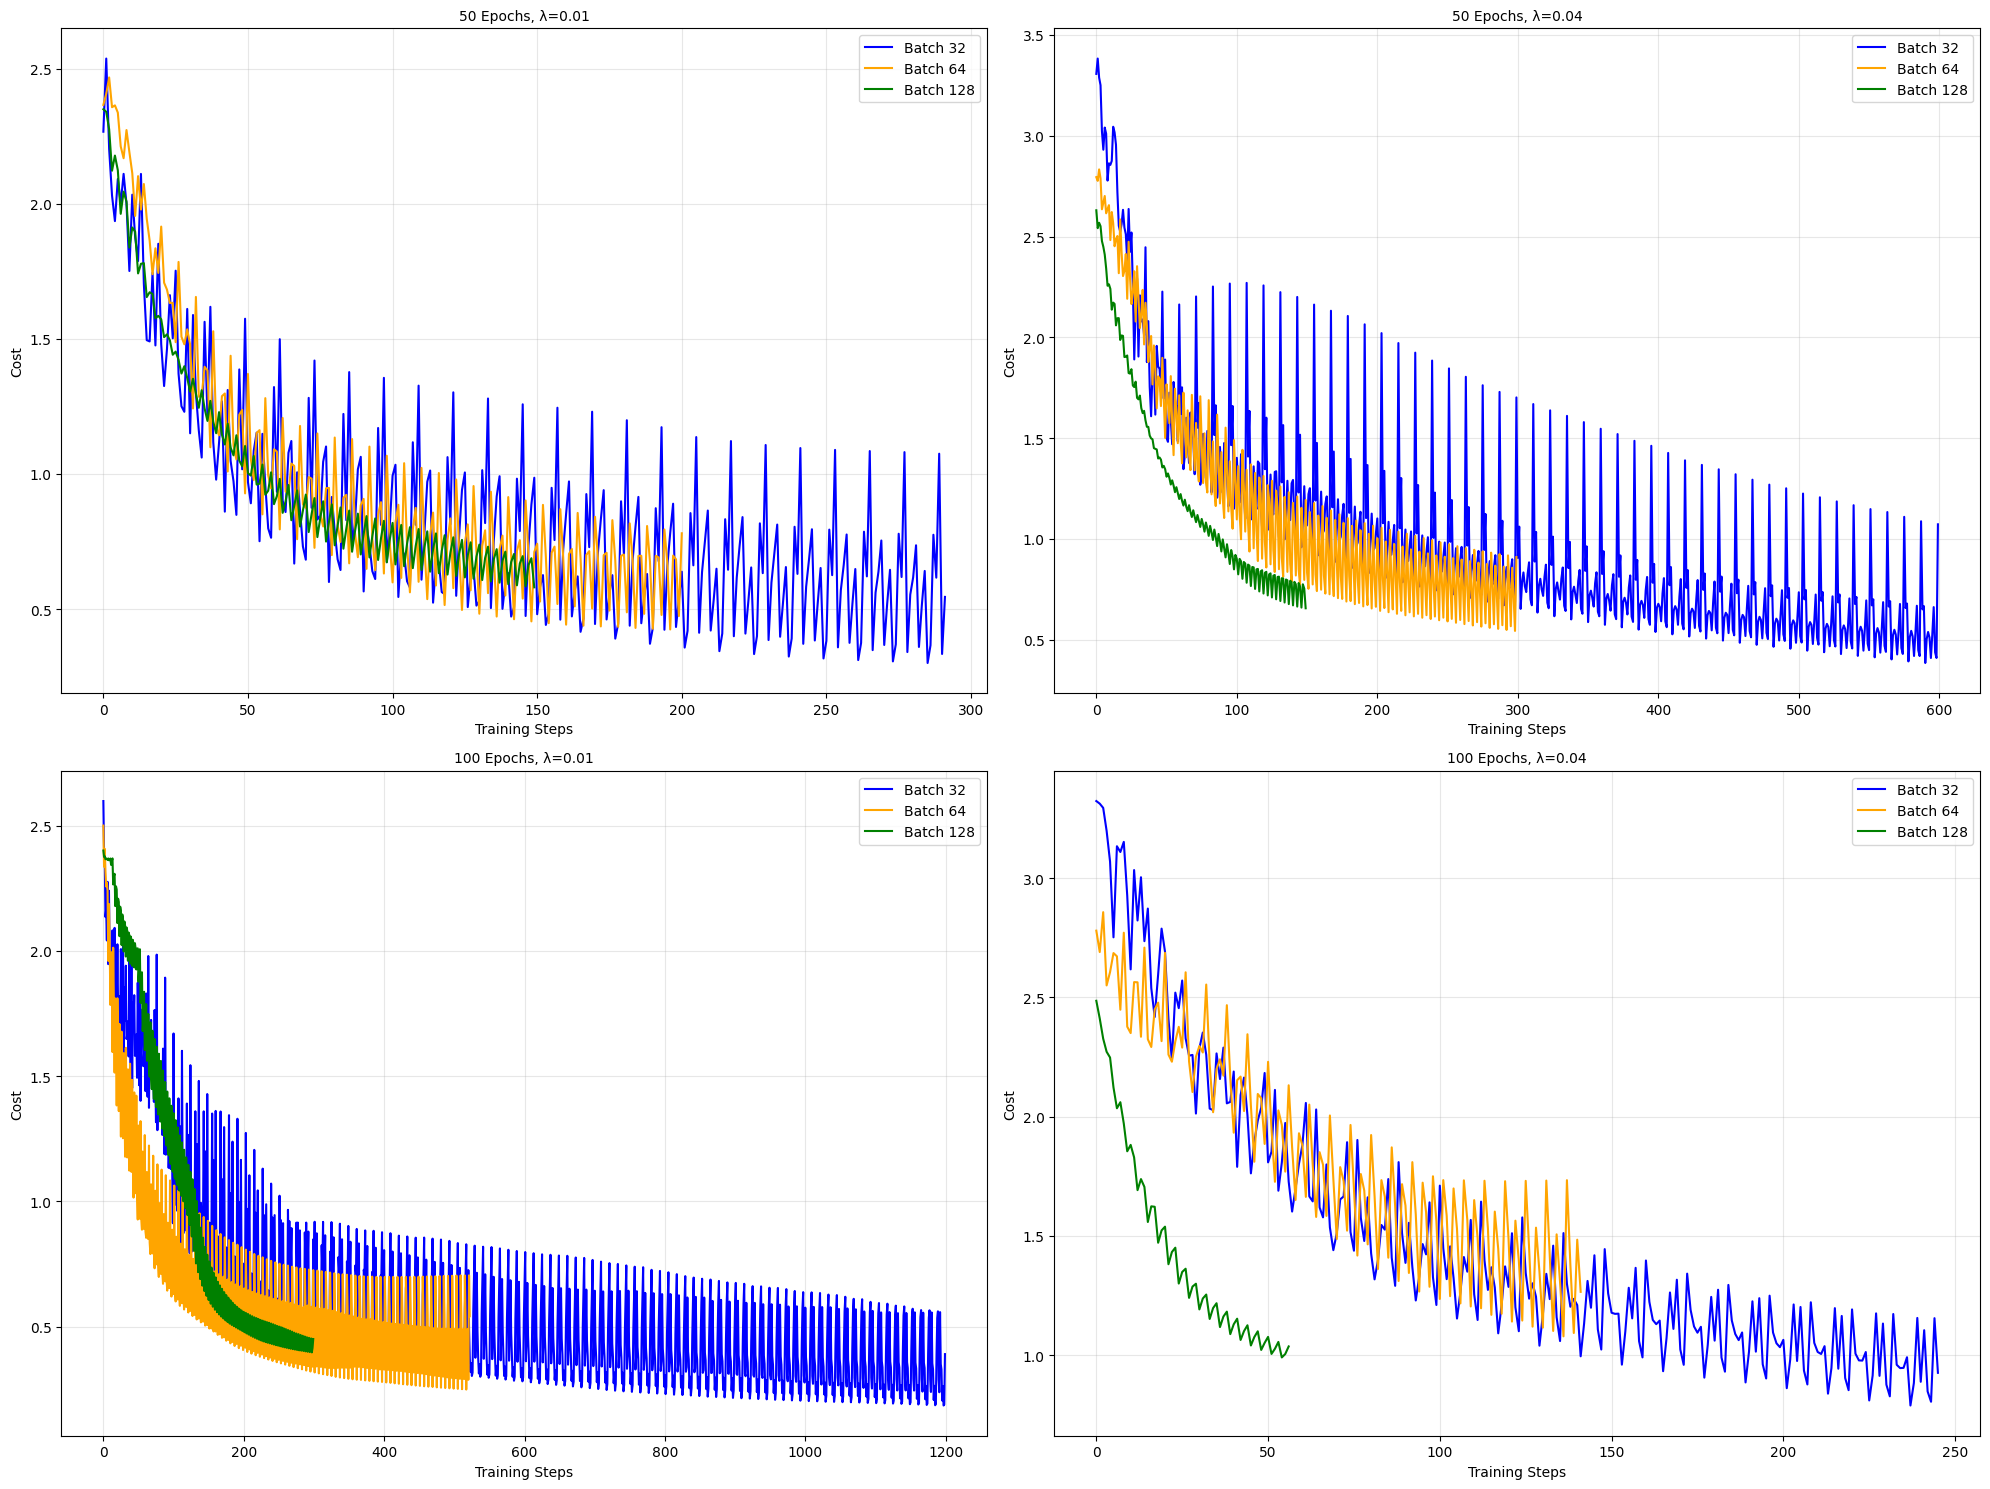

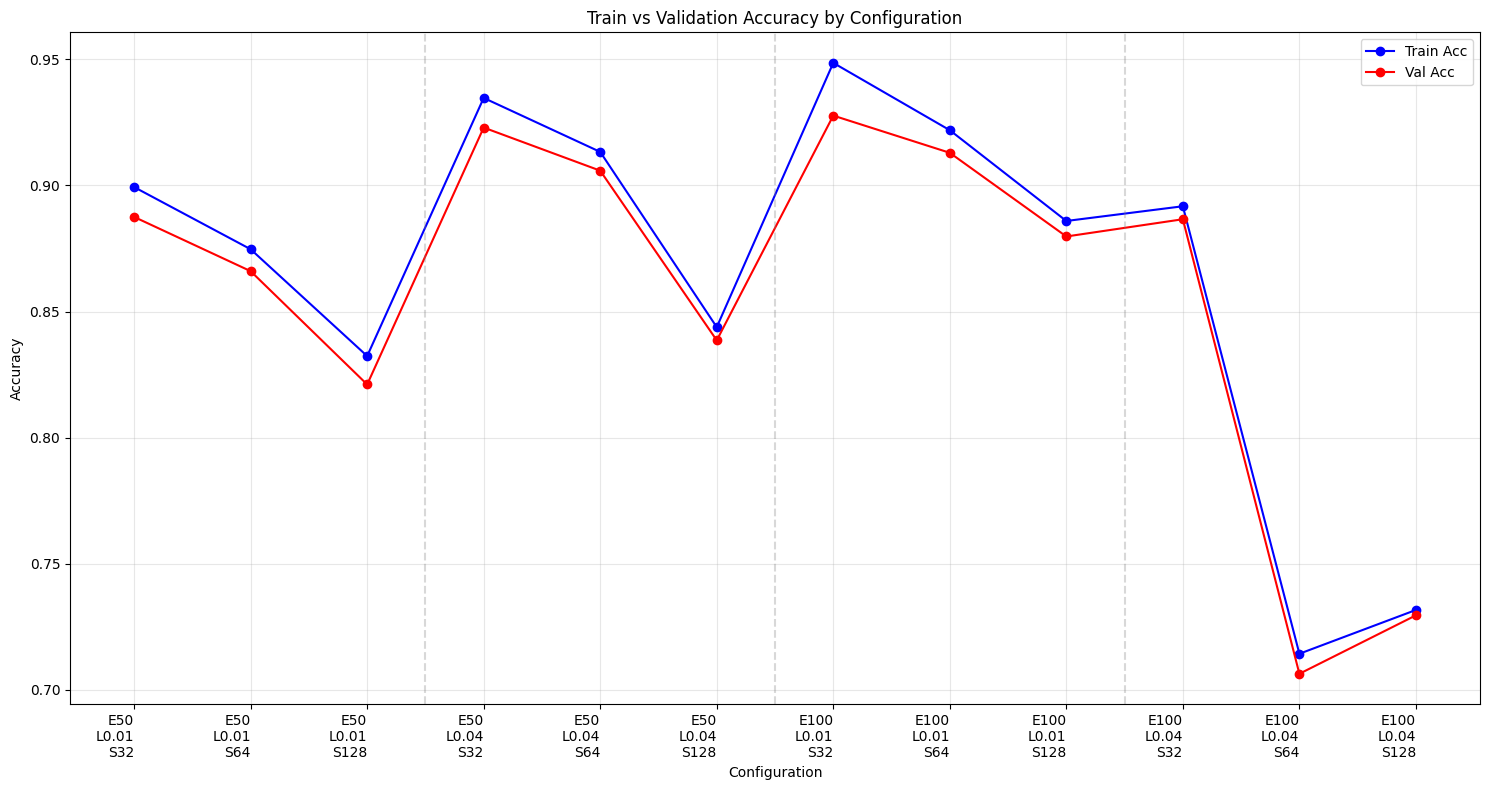

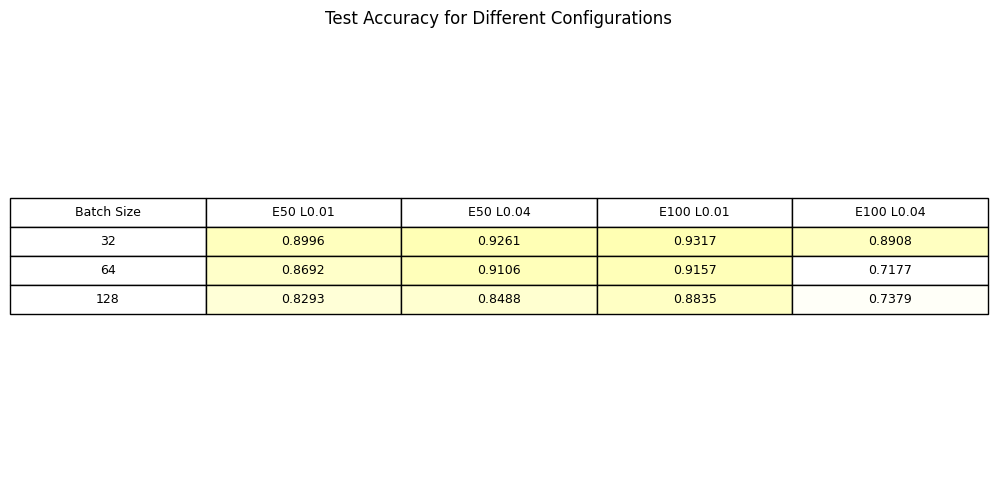


Best Configuration:
Epochs: 100
Batch Size: 32
Lambda: 0.01
Training Time: 138.92 seconds
Training Accuracy: 94.8563%
Validation Accuracy: 92.7667%
Test Accuracy: 93.1700%

Experiment completed.


In [ ]:
if __name__ == "__main__":
    results = run_experiment()


---


**BEST hyperparameter:**

    Epochs = 100

    Batch size = 32

    Lambda L2 value = 0.01

**Results**:

Training Accuracy: 94.85%

Validation Accuracy: 92.76%

Test Accuracy: 93.17%


---



# Run experiments for the best parameters without (Q4) and with (Q5) batch normalization & with L2 (Q6):

In [154]:
def run_experiments_for_best_params():
    """
    Runs experiments for the best parameters with and without batch normalization,
    and plots train and validation costs.
    """

    print("Loading MNIST dataset ...")
    # Load and preprocess MNIST dataset
    X_train, Y_train, X_val, Y_val, X_test, Y_test = load_and_preprocess_mnist()

    # best parameters
    best_batch_size = 32
    best_lambda = 0.01
    num_epochs = 100
    learning_rate = 0.009
    layers_dims = [784, 20, 7, 5, 10]

    # run experiments for best parameters:
    results = {}

    # Experiment 1: Without Batch Normalization & Without L2
    print("\nRuning Experiment 1: Without Batch Normalization & Without L2")
    results["Experiment 1: Without Batch Normalization & Without L2"] = run_single_experiment(
        X_train, Y_train, X_val, Y_val, X_test, Y_test,
        layers_dims, learning_rate, num_epochs, best_batch_size,
        use_batchnorm=False, L2=0.0, experiment_name="Experiment 1: Without Batch Normalization & Without L2"
    )

    # Experiment 2: With Batch Normalization & With L2
    print("\nRuning Experiment 2: With Batch Normalization & With L2")
    results["Experiment 2: With Batch Normalization & With L2"] = run_single_experiment(
        X_train, Y_train, X_val, Y_val, X_test, Y_test,
        layers_dims, learning_rate, num_epochs, best_batch_size,
        use_batchnorm=True, L2=best_lambda, experiment_name="Experiment 2: With Batch Normalization & With L2"
    )

    # Experiment 3: Without Batch Normalization & With L2
    print("\nRuning Experiment 3: Without Batch Normalization & With L2")
    results["Experiment 3: Without Batch Normalization & With L2"] = run_single_experiment(
        X_train, Y_train, X_val, Y_val, X_test, Y_test,
        layers_dims, learning_rate, num_epochs, best_batch_size,
        use_batchnorm=False, L2=best_lambda, experiment_name="Experiment 3: Without Batch Normalization & With L2"
    )

    # Experiment 4: With Batch Normalization & Without L2
    print("\nRuning Experiment 4: With Batch Normalization & Without L2")
    results["Experiment 4: With Batch Normalization & Without L2"] = run_single_experiment(
        X_train, Y_train, X_val, Y_val, X_test, Y_test,
        layers_dims, learning_rate, num_epochs, best_batch_size,
        use_batchnorm=True, L2=0.0, experiment_name="Experiment 4: With Batch Normalization & Without L2"
    )

    return results


def run_single_experiment(X_train, Y_train, X_val, Y_val, X_test, Y_test,
                          layers_dims, learning_rate, num_epochs, batch_size,
                          use_batchnorm, L2, experiment_name):
    """
    Runs a single experiment and calculates train and validation costs and accuracy.
    """
    # start Time:
    start_time = time.time()

    # Train model:
    parameters, _ = l_layer_model(
        X_train, Y_train,
        layers_dims=layers_dims,
        learning_rate=learning_rate,
        num_iterations=num_epochs,
        batch_size=batch_size,
        use_batchnorm=use_batchnorm,
        L2=L2
    )

    # End Time:
    training_time = time.time() - start_time

    train_acc = predict(X_train, Y_train, parameters, use_batchnorm)
    val_acc = predict(X_val, Y_val, parameters, use_batchnorm)
    test_acc = predict(X_test, Y_test, parameters, use_batchnorm)

    # print(ex_train_costs)
    # print(ex_val_costs)

    # print plots:
    plot_experiment_costs(ex_train_costs, ex_val_costs, experiment_name)

    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Train Accuracy: {train_acc:.4%}, Val Accuracy: {val_acc:.4%}, Test Accuracy: {test_acc:.4%}")

    # Save weights for analysis
    weights_analysis = {key: value for key, value in parameters.items() if key.startswith('W')}


    return {
        "parameters": parameters,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "test_acc": test_acc,
        "train_costs": ex_train_costs,
        "val_costs": ex_val_costs,
        "weights_analysis": weights_analysis
    }


def plot_experiment_costs(train_costs, val_costs, experiment_name):
    """
    Plots the train and validation costs for a single experiment.
    """

    x1= [i for i in range(len(train_costs))]
    x2= [i for i in range(len(val_costs))]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 6)

    fig.suptitle(f"{experiment_name} - Train Vs. Validation Costs")

    ax1.plot(x1, train_costs)
    ax1.set_title("Train Costs")
    ax1.set_xlabel("Training Steps")
    ax1.set_ylabel("Cost")

    ax2.plot(x2, val_costs)
    ax2.set_title("Validation Costs")
    ax2.set_xlabel("Training Steps")
    ax2.set_ylabel("Cost")

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit titles
    plt.show()



In [155]:
def compare_weights(results, experiment_number=None):
    """
    Compare weights for a specific experiment or all experiments.

    Parameters:
        results (dict): Dictionary containing experiment results.
        experiment_number (int, optional): The number of the experiment to analyze.
            If None, analyze all experiments.
    """
    if experiment_number is not None:
        # Validate experiment number
        experiment_key = f"Experiment {experiment_number}:"
        matching_experiments = [key for key in results.keys() if key.startswith(experiment_key)]
        if not matching_experiments:
            print(f"Experiment {experiment_number} not found in results.")
            return
        experiments_to_analyze = matching_experiments
    else:
        # Analyze all experiments
        experiments_to_analyze = results.keys()

    for experiment in experiments_to_analyze:
        print(f"\nAnalyzing weights for {experiment}...")
        weights = results[experiment]["weights_analysis"]
        for layer, weight_matrix in weights.items():
            # Convert weight_matrix to NumPy array if it's a PyTorch tensor
            if isinstance(weight_matrix, torch.Tensor):
                weight_matrix = weight_matrix.detach().numpy()

            print(f"Layer: {layer}")
            print(f"Mean: {np.mean(weight_matrix):.4f}, Std: {np.std(weight_matrix):.4f}, Max: {np.max(weight_matrix):.4f}, Min: {np.min(weight_matrix):.4f}")

        plot_weights_distribution(weights, experiment)


def plot_weights_distribution(weights, experiment_name):
    """
    Plots the weight distributions for each layer.

    Parameters:
        weights (dict): Dictionary of weight matrices for layers (e.g., {"W1": matrix, ...}).
        experiment_name (str): Name of the experiment for the plot title.
    """
    num_layers = len(weights)
    fig, axes = plt.subplots(num_layers, 1, figsize=(8, 4 * num_layers))

    for i, (layer, weight_matrix) in enumerate(weights.items()):
        # Convert weight_matrix to NumPy array if it's a PyTorch tensor
        if isinstance(weight_matrix, torch.Tensor):
            weight_matrix = weight_matrix.detach().numpy()

        ax = axes[i] if num_layers > 1 else axes
        ax.hist(weight_matrix.flatten(), bins=50, alpha=0.7, density=True, label=layer)
        ax.set_title(f"Weight Distribution for {layer}")
        ax.set_xlabel("Weight Values")
        ax.set_ylabel("Density")
        ax.legend()

    plt.suptitle(f"Weights Distribution for {experiment_name}\n")
    plt.tight_layout()
    plt.show()

In [89]:
def compare_weights_difference_direct(results, experiment_num1, experiment_num2, title):
    """
    Compares the weights between two experiments and calculates the direct differences.

    Parameters:
        results (dict): Dictionary containing experiment results.
        experiment_num1 (int): The number of the first experiment to compare.
        experiment_num2 (int): The number of the second experiment to compare.

    Returns:
        dict: A dictionary with layer names as keys and the direct differences as values.
    """
    # Find experiment keys by prefix
    experiment_key1 = next((key for key in results if key.startswith(f"Experiment {experiment_num1}:")), None)
    experiment_key2 = next((key for key in results if key.startswith(f"Experiment {experiment_num2}:")), None)

    if experiment_key1 not in results or experiment_key2 not in results:
        raise ValueError(f"One or both experiments ({experiment_num1}, {experiment_num2}) not found in results.")

    # Get weights for both experiments
    weights1 = results[experiment_key1]["weights_analysis"]
    weights2 = results[experiment_key2]["weights_analysis"]

    # Initialize dictionary to store differences
    differences = {}

    for layer in weights1.keys():
        if layer in weights2:
            # Convert to numpy if needed
            w1 = weights1[layer]
            w2 = weights2[layer]
            if isinstance(w1, torch.Tensor):
                w1 = w1.detach().numpy()
            if isinstance(w2, torch.Tensor):
                w2 = w2.detach().numpy()

            # Calculate direct differences
            diff = w1 - w2
            differences[layer] = diff

            # Print the differences
            print(f"\nThe weight Differences Matrix between {title} in Layer {layer}:\n{diff}")
            print(f"Mean Difference: {np.mean(diff):.4f}, Max Difference: {np.max(diff):.4f}, Min Difference: {np.min(diff):.4f}")
        else:
            print(f"Layer {layer} not found in both experiments.")

    return differences


**please note:** The code below **ONLY** work when l_layer_model is altered to save costs in the global parameters.

Loading MNIST dataset ...

Runing Experiment 1: Without Batch Normalization & Without L2
Cost after 100 training steps: 2.25097
Cost after 200 training steps: 2.23297
Cost after 300 training steps: 2.23442
Cost after 400 training steps: 2.21728
Cost after 500 training steps: 2.11475
Cost after 600 training steps: 1.92553
Cost after 700 training steps: 1.94697
Cost after 800 training steps: 2.13559
Cost after 900 training steps: 1.89643
Cost after 1000 training steps: 1.76942
Cost after 1100 training steps: 1.86571
Cost after 1200 training steps: 2.03747
Cost after 1300 training steps: 1.87726
Cost after 1400 training steps: 1.86738
Cost after 1500 training steps: 1.87342
Cost after 1600 training steps: 1.72979
Cost after 1700 training steps: 1.56984
Cost after 1800 training steps: 1.56476
Cost after 1900 training steps: 1.59326
Cost after 2000 training steps: 1.91082
Cost after 2100 training steps: 1.60042
Cost after 2200 training steps: 1.48684
Cost after 2300 training steps: 1.45331


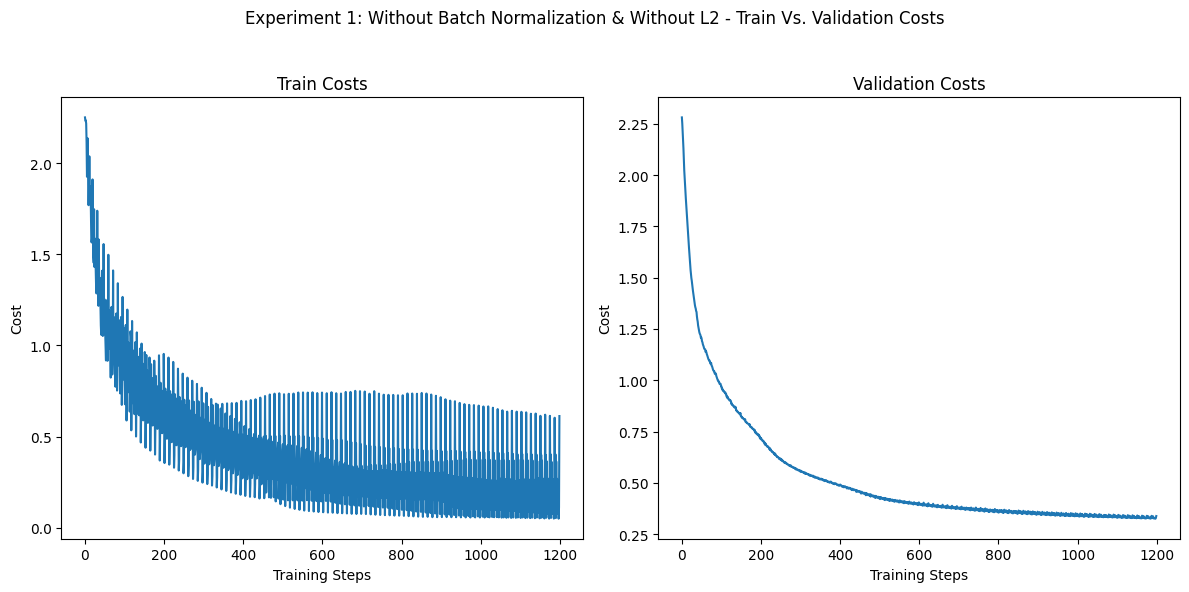

Training Time: 138.77 seconds
Train Accuracy: 93.0917%, Val Accuracy: 91.5333%, Test Accuracy: 91.9300%

Runing Experiment 2: With Batch Normalization & With L2
Cost after 100 training steps: 2.85047
Cost after 200 training steps: 2.26264
Cost after 300 training steps: 2.496
Cost after 400 training steps: 2.483
Cost after 500 training steps: 2.54288
Cost after 600 training steps: 2.15502
Cost after 700 training steps: 2.14054
Cost after 800 training steps: 2.21207
Cost after 900 training steps: 2.3129
Cost after 1000 training steps: 2.04579
Cost after 1100 training steps: 1.98034
Cost after 1200 training steps: 2.20691
Cost after 1300 training steps: 2.08388
Cost after 1400 training steps: 1.93194
Cost after 1500 training steps: 1.85021
Cost after 1600 training steps: 1.89441
Cost after 1700 training steps: 1.70934
Cost after 1800 training steps: 1.68216
Cost after 1900 training steps: 1.76761
Cost after 2000 training steps: 1.77538
Cost after 2100 training steps: 1.89459
Cost after 22

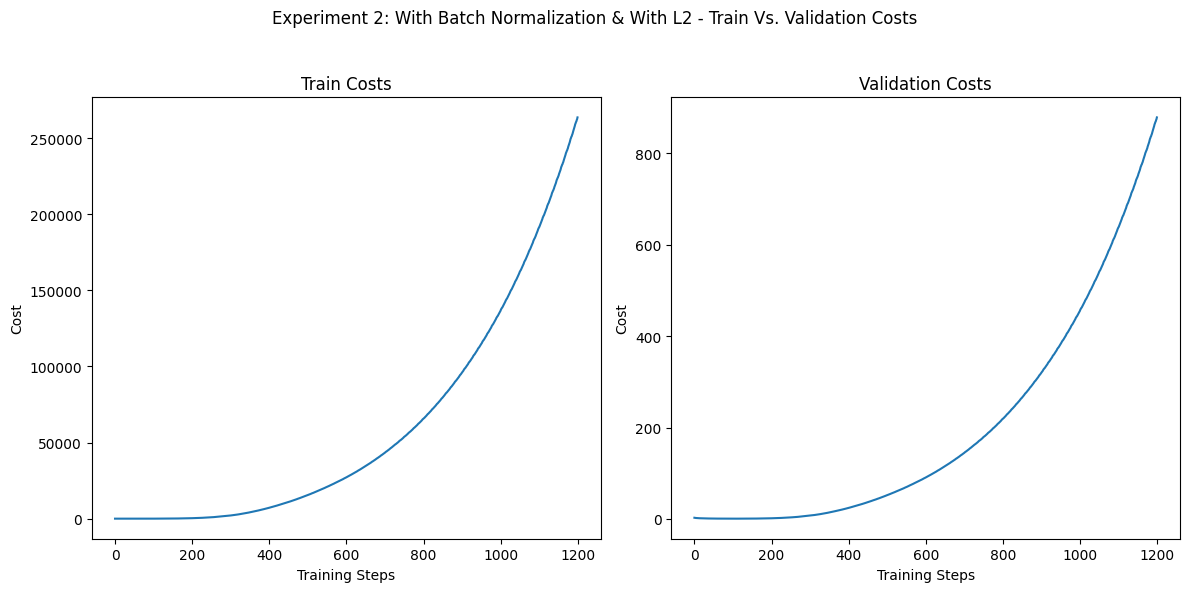

Training Time: 172.91 seconds
Train Accuracy: 93.4208%, Val Accuracy: 92.9000%, Test Accuracy: 93.1300%

Runing Experiment 3: Without Batch Normalization & With L2
Cost after 100 training steps: 2.48426
Cost after 200 training steps: 2.46609
Cost after 300 training steps: 2.30527
Cost after 400 training steps: 2.19244
Cost after 500 training steps: 2.23427
Cost after 600 training steps: 2.62401
Cost after 700 training steps: 2.0888
Cost after 800 training steps: 2.35985
Cost after 900 training steps: 2.22355
Cost after 1000 training steps: 1.95948
Cost after 1100 training steps: 2.32113
Cost after 1200 training steps: 2.32806
Cost after 1300 training steps: 1.93166
Cost after 1400 training steps: 2.06041
Cost after 1500 training steps: 1.91788
Cost after 1600 training steps: 1.72806
Cost after 1700 training steps: 1.7319
Cost after 1800 training steps: 2.28699
Cost after 1900 training steps: 1.50682
Cost after 2000 training steps: 1.83901
Cost after 2100 training steps: 1.86416
Cost af

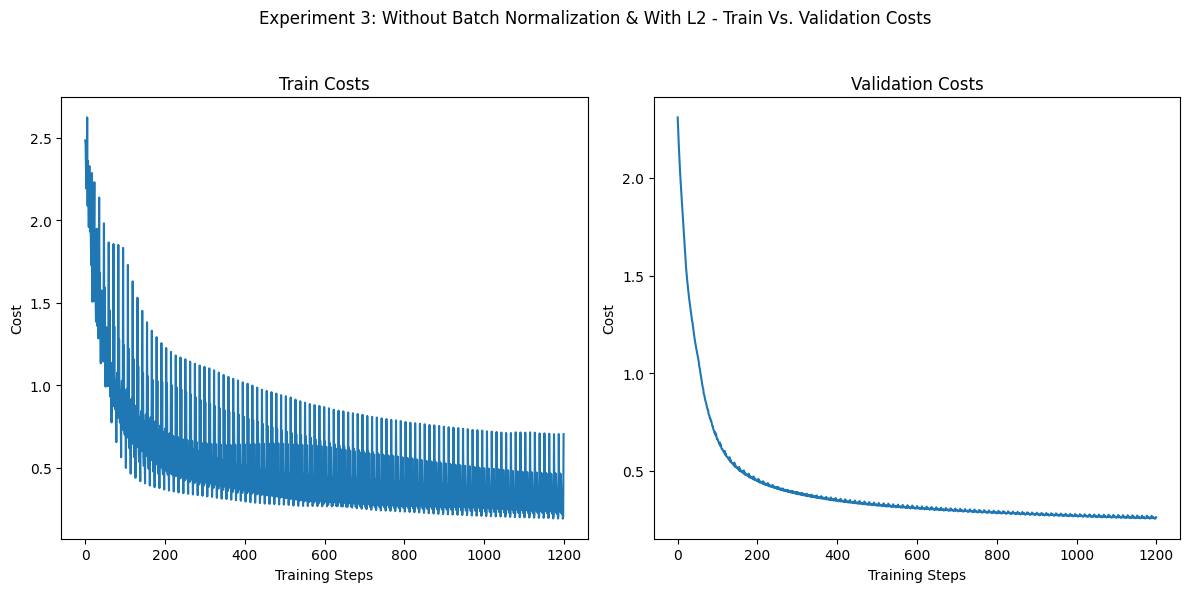

Training Time: 142.40 seconds
Train Accuracy: 94.2271%, Val Accuracy: 92.7333%, Test Accuracy: 92.9300%

Runing Experiment 4: With Batch Normalization & Without L2
Cost after 100 training steps: 2.38806
Cost after 200 training steps: 2.1694
Cost after 300 training steps: 1.86082
Cost after 400 training steps: 2.00141
Cost after 500 training steps: 2.07422
Cost after 600 training steps: 1.84269
Cost after 700 training steps: 1.79133
Cost after 800 training steps: 1.64578
Cost after 900 training steps: 1.59025
Cost after 1000 training steps: 1.49285
Cost after 1100 training steps: 1.56292
Cost after 1200 training steps: 1.6359
Cost after 1300 training steps: 1.6362
Cost after 1400 training steps: 1.58579
Cost after 1500 training steps: 1.44625
Cost after 1600 training steps: 1.26421
Cost after 1700 training steps: 1.48359
Cost after 1800 training steps: 1.51834
Cost after 1900 training steps: 1.41989
Cost after 2000 training steps: 1.21678
Cost after 2100 training steps: 1.19042
Cost aft

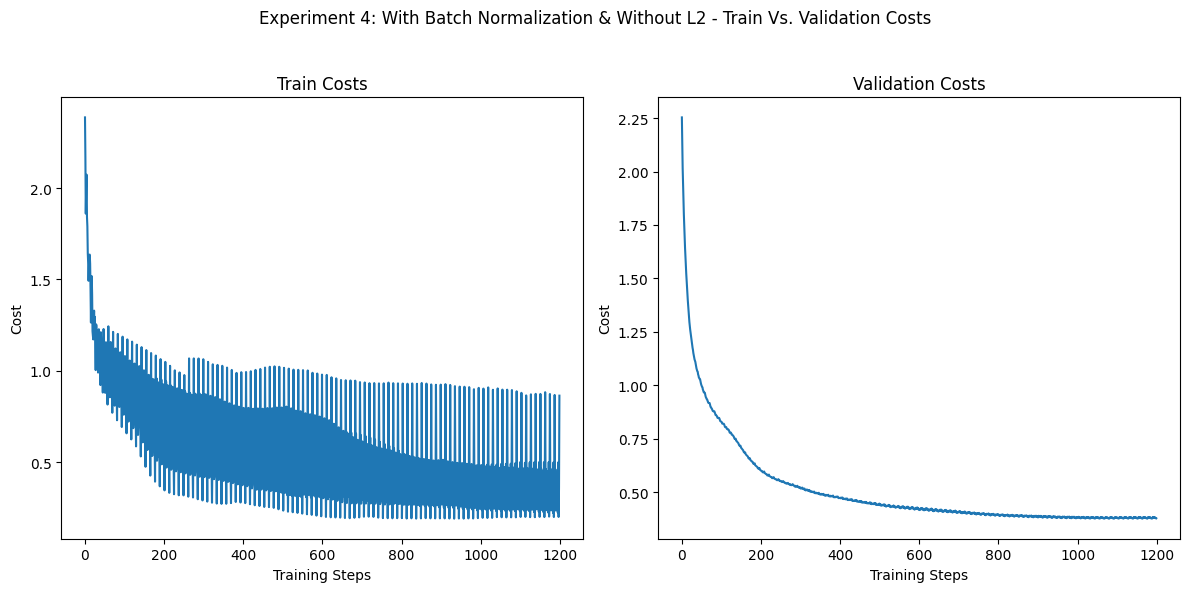

Training Time: 173.57 seconds
Train Accuracy: 89.4979%, Val Accuracy: 88.2000%, Test Accuracy: 89.4100%


In [157]:
results = run_experiments_for_best_params()

**FOR Q6:**


Analyzing weights for Experiment 1: Without Batch Normalization & Without L2...
Layer: W1
Mean: -0.0048, Std: 0.3169, Max: 1.3053, Min: -1.3068
Layer: W2
Mean: 0.0321, Std: 0.6014, Max: 2.2388, Min: -1.7439
Layer: W3
Mean: 0.1438, Std: 0.8160, Max: 2.0970, Min: -1.7146
Layer: W4
Mean: 0.0227, Std: 0.7180, Max: 1.3909, Min: -1.4711


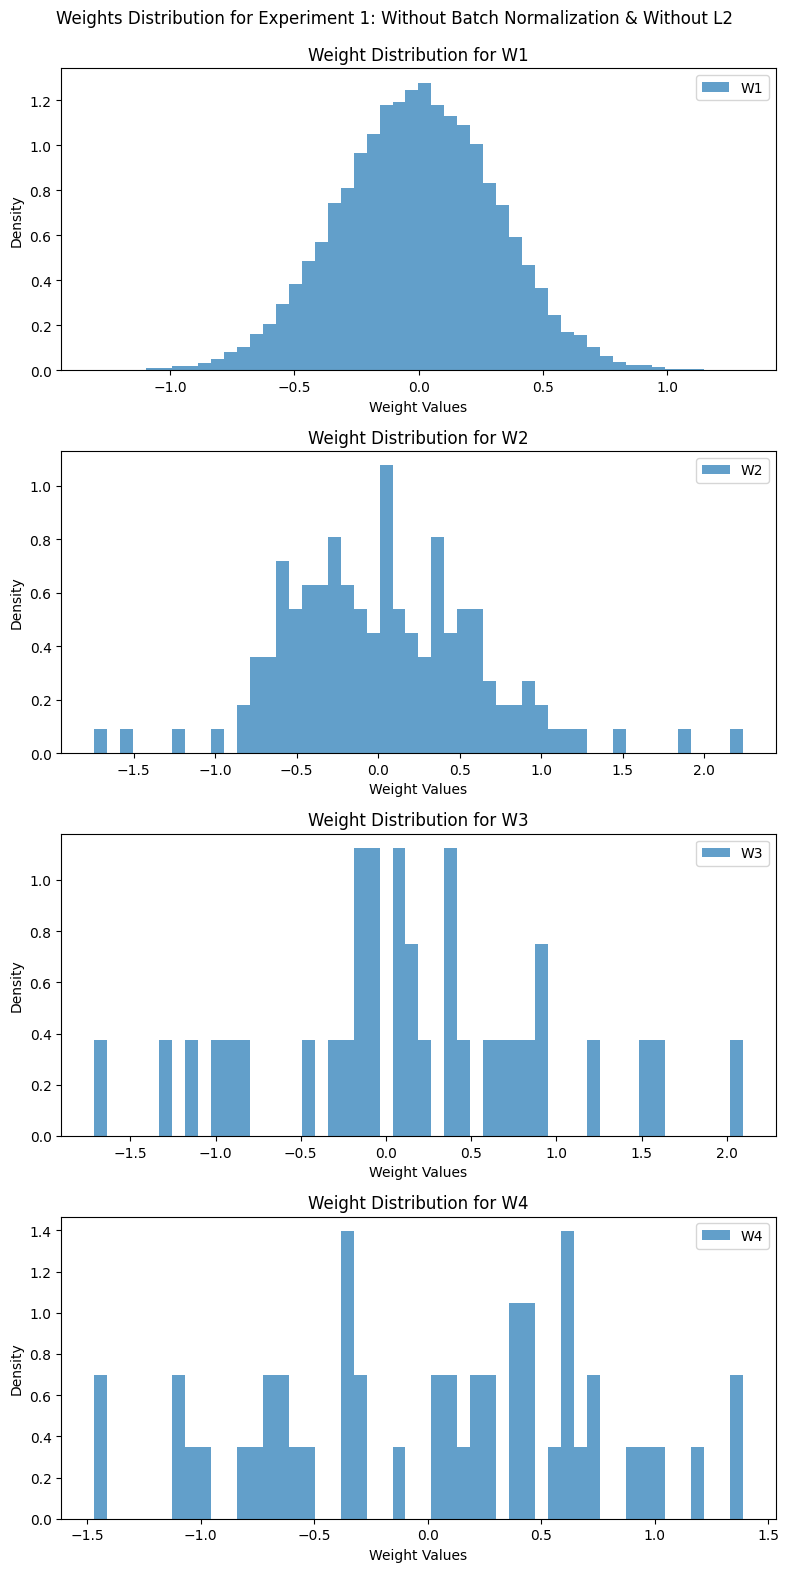

In [158]:
compare_weights(results, experiment_number=1)


Analyzing weights for Experiment 3: Without Batch Normalization & With L2...
Layer: W1
Mean: 0.0007, Std: 0.2279, Max: 0.8903, Min: -1.0667
Layer: W2
Mean: 0.0198, Std: 0.4227, Max: 1.1625, Min: -0.9870
Layer: W3
Mean: 0.1589, Std: 0.6116, Max: 1.2690, Min: -0.9288
Layer: W4
Mean: -0.0204, Std: 0.6047, Max: 1.2676, Min: -1.3002


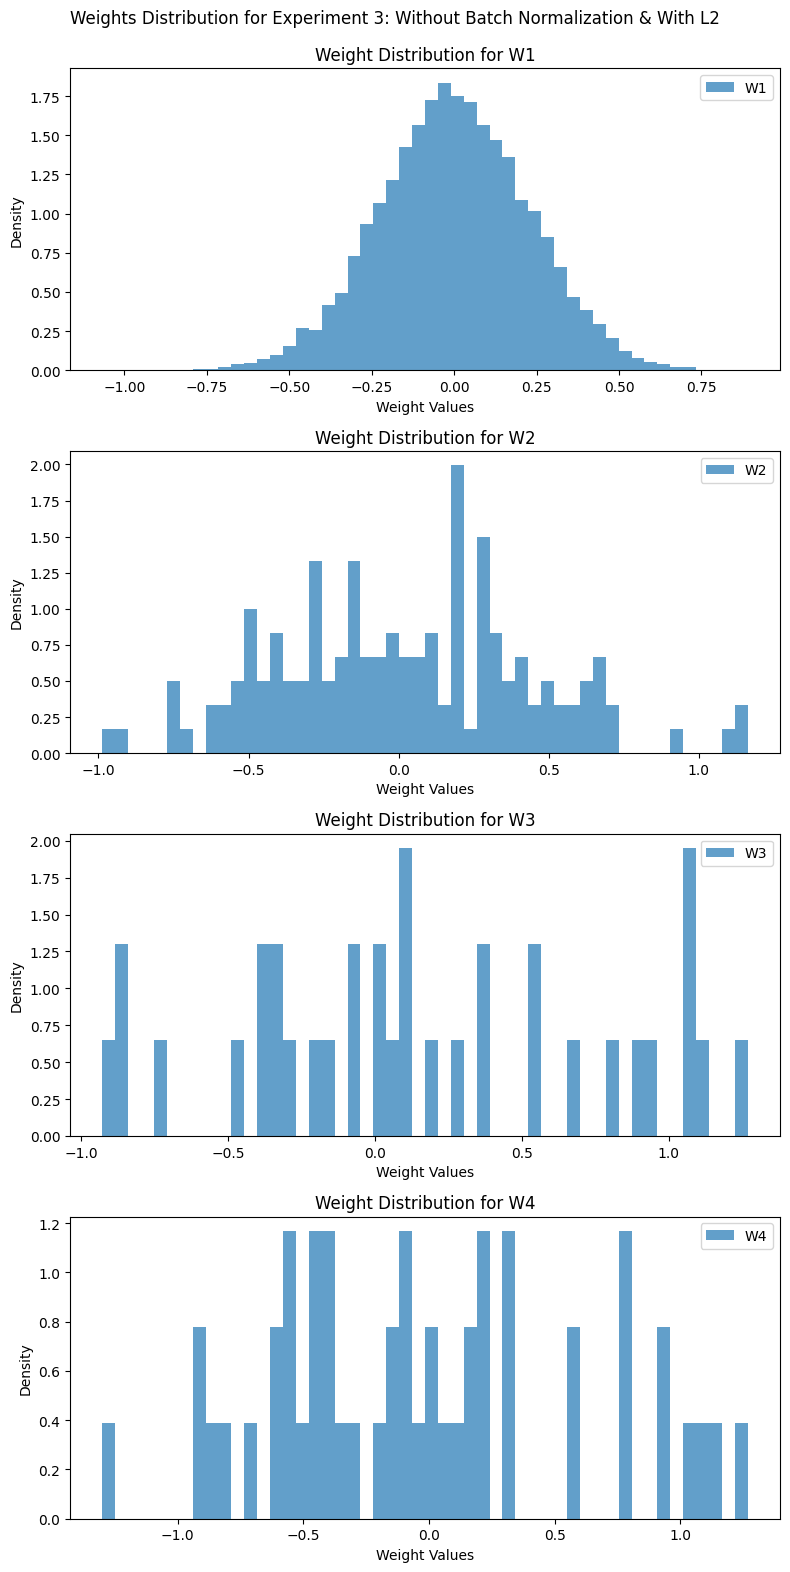

In [159]:
compare_weights(results, experiment_number=3)

In [160]:
title = "Not using L2 (Experiment 1) and using L2 (Experiment 3)"
compare_weights_difference_direct(results, 1, 3, title)


The weight Differences Matrix between Not using L2 (Experiment 1) and using L2 (Experiment 3) in Layer W1:
[[-0.63373893  0.1668123   0.4887274  ... -0.57527125 -0.36753783
  -0.11092481]
 [ 0.80213195 -0.15664989  0.5427708  ... -0.16009195 -0.09240482
   0.14301226]
 [ 0.00872636  0.17570028 -0.24094678 ... -0.4847973  -0.79922855
  -0.36871603]
 ...
 [-0.63760984 -0.12622774 -0.44158962 ... -0.18586603 -0.27165887
   0.5335406 ]
 [ 0.518296   -0.12111321  0.57821655 ...  0.09562492 -0.24146545
   0.2557825 ]
 [-0.02036203 -0.8189572   0.60552466 ...  0.1106827  -0.4840657
  -0.22089154]]
Mean Difference: -0.0055, Max Difference: 1.5193, Min Difference: -1.5530

The weight Differences Matrix between Not using L2 (Experiment 1) and using L2 (Experiment 3) in Layer W2:
[[-9.70051885e-01 -4.71507013e-02 -2.90508270e-01 -1.27158001e-01
   1.09016943e+00  9.82940376e-01 -1.78311110e+00  8.11386883e-01
   1.06872678e-01  1.07288492e+00 -2.76645362e-01 -7.21178174e-01
   1.96140289e-01  6.

{'W1': array([[-0.63373893,  0.1668123 ,  0.4887274 , ..., -0.57527125,
         -0.36753783, -0.11092481],
        [ 0.80213195, -0.15664989,  0.5427708 , ..., -0.16009195,
         -0.09240482,  0.14301226],
        [ 0.00872636,  0.17570028, -0.24094678, ..., -0.4847973 ,
         -0.79922855, -0.36871603],
        ...,
        [-0.63760984, -0.12622774, -0.44158962, ..., -0.18586603,
         -0.27165887,  0.5335406 ],
        [ 0.518296  , -0.12111321,  0.57821655, ...,  0.09562492,
         -0.24146545,  0.2557825 ],
        [-0.02036203, -0.8189572 ,  0.60552466, ...,  0.1106827 ,
         -0.4840657 , -0.22089154]], dtype=float32),
 'W2': array([[-9.70051885e-01, -4.71507013e-02, -2.90508270e-01,
         -1.27158001e-01,  1.09016943e+00,  9.82940376e-01,
         -1.78311110e+00,  8.11386883e-01,  1.06872678e-01,
          1.07288492e+00, -2.76645362e-01, -7.21178174e-01,
          1.96140289e-01,  6.45311475e-02,  2.00438833e+00,
         -5.03063679e-01,  2.38035172e-02,  2.